In [53]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [62]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [63]:
grid = pd.read_csv('combined.csv')

In [64]:
grid_dates_corrected = []; year = []; doy = []

for date in grid.SETTLEMENT_DATE.values:
    grid_dates_corrected.append(datetime.date(year=int(date[7:]), month=months[date[3:6].capitalize()], day=int(date[:2])))
    year.append(grid_dates_corrected[-1].year)
    doy.append(grid_dates_corrected[-1].timetuple().tm_yday)

grid['DATE_FULL'] = grid_dates_corrected; grid['YEAR'] = year; grid['DOY'] = doy

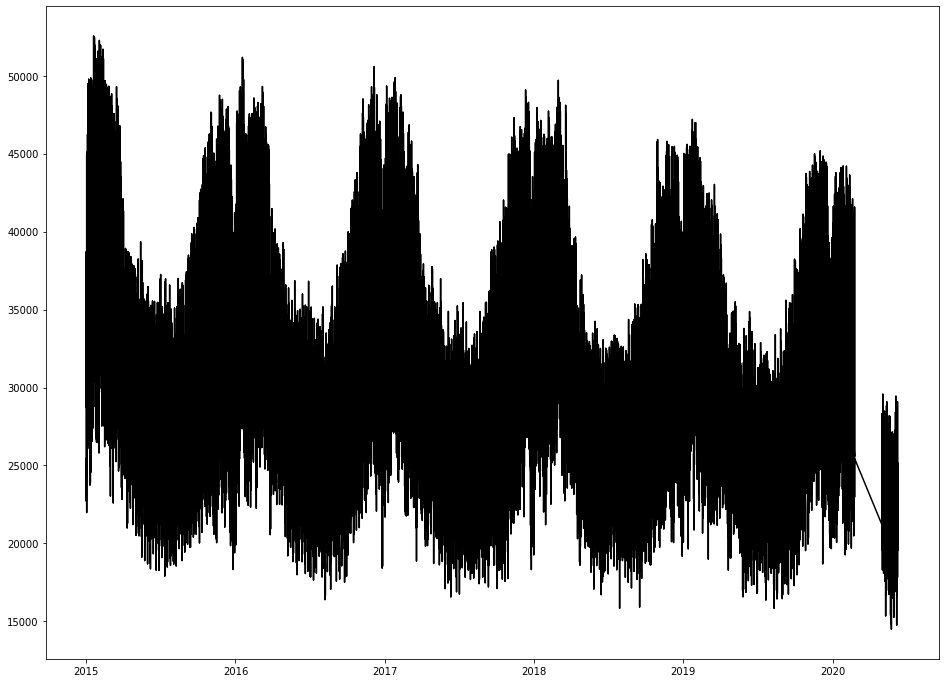

In [67]:
plt.figure(figsize=(16,12))
plt.plot(grid.DATE_FULL, grid.ND, c='k')
plt.show()

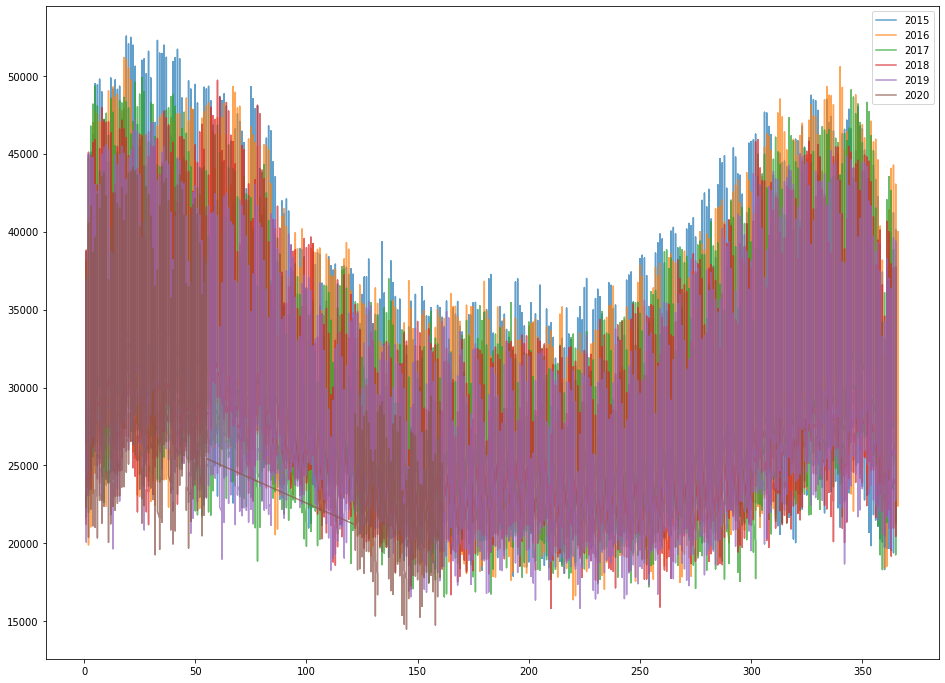

In [66]:
plt.figure(figsize=(16,12))
for year in np.unique(grid.YEAR.values):
    plt.plot(grid.DOY[grid.YEAR.values==year], grid.ND[grid.YEAR.values==year], alpha=0.7, label=str(year))
plt.legend()
plt.show()